In [ ]:
Titanic Classifcation
- My take on this common question using Naive Bayes
- Accuracy ~ 0.8

In [293]:


import numpy as np
import pandas as pd

import os


%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import MultinomialNB


In [294]:
df = pd.read_csv("/Users/ryanjeon/Desktop/ABE516/516x/module3/Titanic/train.csv")
print(df.shape)

(891, 12)


Our main research objective here, is to find patterns between passenger variables in the Titanic test dataset that can cross over to our Titanic training dataset to predict whether a passanger survived. Remember, the test and training come from the same dataset, so we need not worry about inferences. I am personally curious to know if I re-mixed the data, what that does to our prediction. 

In [295]:
df.describe() 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [296]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [297]:
df.isnull().sum(axis = 0)

# this already tells me that cabin is going to be a problem.
# I don't know of a way to impute the NAs in age- but maybe we don't need to touch that atm

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [298]:
# Curious to know what the "overall" survival rates of men and women are. Ez gimmie points

#ladies = titanic_train.loc[titanic_train.Sex == 'female']
#ladies_survived = ladies["Survived"]
#rate_ladies = len(ladies_survived)/len(ladies)
# print(rate_ladies, "of the ladies on Titanic survived")

# Here is the first gotcha- survived is a binary trait, so finding the length is equal to all of it.
# Need to SUM the column, to add up all the 1s, and ignoreing the 0s (deaths)

ladies = df.loc[df.Sex == 'female']
ladies_survived = ladies["Survived"]
rate_ladies = sum(ladies_survived)/len(ladies)
print(rate_ladies, "of the ladies on Titanic survived")

males = df.loc[df.Sex == 'male']
males_survived = males["Survived"]
rate_males = sum(males_survived)/len(males)
print(rate_males, "of the males on Titanic survived")

0.7420382165605095 of the ladies on Titanic survived
0.18890814558058924 of the males on Titanic survived


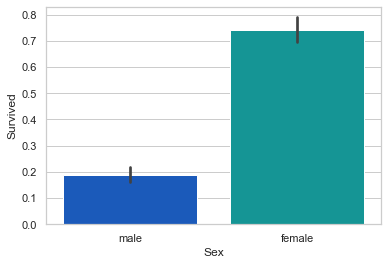

In [299]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Sex", y="Survived", data=df, palette = "winter")

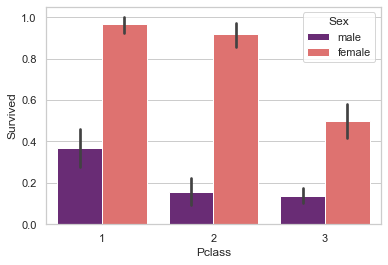

In [300]:
ax = sns.barplot(x="Pclass", y="Survived", hue="Sex", data=df, palette="magma")

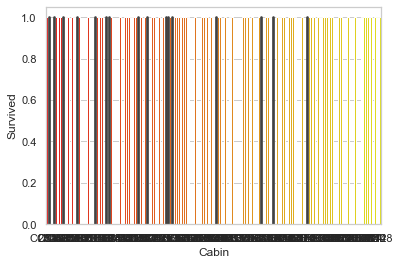

In [301]:
ax = sns.barplot(x="Cabin", y="Survived", data=df, palette = "autumn")

# Well that doesn't look right- let's take a more special look at cabin:

In [302]:
df['Cabin'].unique()
# well that explains it- lets only keep the first letter


array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [303]:
df["Cabin"]=df["Cabin"].str.slice(0,1)
df['Cabin'].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [304]:
# lets replace the na's in cabin with something arbitrary like N... for NA
df=df.fillna({"Cabin":'N'})

In [305]:
test = df.groupby("Cabin")["Survived"].mean()
test.head


<bound method NDFrame.head of Cabin
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
N    0.299854
T    0.000000
Name: Survived, dtype: float64>

In [306]:
test = test.reset_index()

test.head()
    
    



,Cabin,Survived
0,A,0.466667
1,B,0.744681
2,C,0.593220
3,D,0.757576
4,E,0.750000


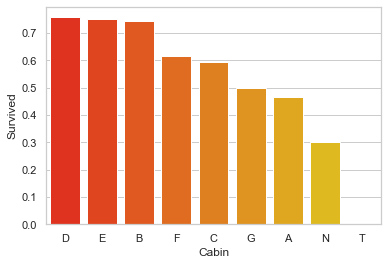

In [307]:
test= test.sort_values(by = "Survived", ascending=False)
ax = sns.barplot(x="Cabin", y="Survived", data=test, palette = "autumn")

# IT WORKS!!!! WOW! and is so beautiful! but these letters are cateogrical- ML doesn't like that so lets convert them to hard coded numbers


In [308]:
df['Cabin']=df['Cabin'].replace(['A','B','C','D','E','F','G','T','X', 'N'],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Based on these preliminary analysis, one can say that being a lady on the Titanic gave you substanital odds of survivng the Titanic, while men were very much more likely to die. It also seems like having a T cabin class means you'll probably die on the Titanic. From these plots, is our question answered? Not at all, because this is just one column. We didn't do any real fun yet! It is only by using multiple columns, can we extract useful, but more complex, relationships between multiple variables. 

In [309]:
df.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,9,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,2,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,9,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,2,S


<AxesSubplot:>

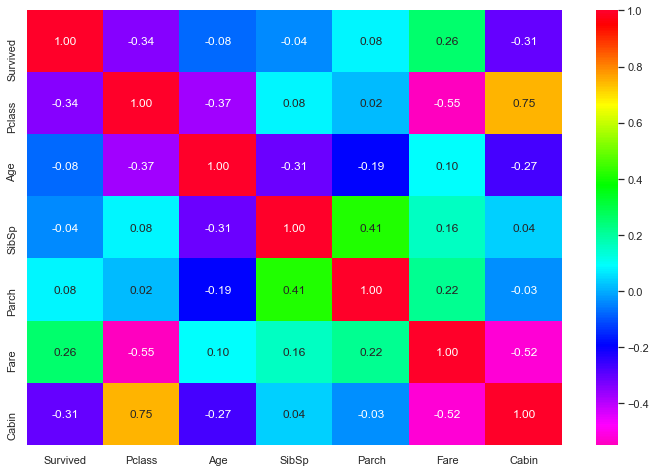

In [310]:
corr = df[df.columns[1:14]].corr()
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(corr, cmap="gist_rainbow_r", annot = True, fmt=".2f")

# we need to make sure our variables are relatively independent 
# one of the statistical assumptions of the NB 

# It does look like Cabin and Pclass are highly correlated.
# Pclass is also moderately correlated to Fare.
# lets remove pclass as a result. 

In [311]:
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,9,S


In [312]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin            int64
Embarked        object
dtype: object

In [313]:
# Lets drop name and ticket 
# we will have to convert some of the categorical variables into numeric..... so sex -> 0/1, embarked -> 1,2,3
df['Sex'] = df['Sex'].replace(["female", "male"], [0,1])
df['Embarked'] = df['Embarked'].replace(['S', 'C', 'Q'], [1, 2, 3])
df['Age'] = pd.qcut(df['Age'], 10, labels=False)

df.dropna(axis=0, inplace=True)
df = df.drop(columns =['Pclass'])
survived = df['Survived']


<AxesSubplot:>

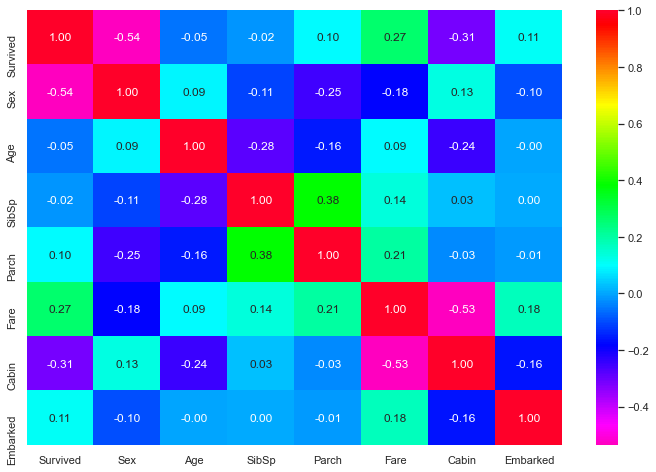

In [314]:
corr = df[df.columns[1:14]].corr()
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(corr, cmap="gist_rainbow_r", annot = True, fmt=".2f")

In [315]:
print(df.columns)

Index(['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [316]:
df.head(1)

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,"Braund, Mr. Owen Harris",1,2.0,1,0,A/5 21171,7.25,9,1.0


In [319]:
df.drop(['Survived', 'PassengerId', 'Name', 'Ticket'], axis = 1, inplace=True)
df.head(1)

KeyError: "['Survived' 'PassengerId' 'Name' 'Ticket'] not found in axis"

In [320]:
df.head(1)

,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,2.0,1,0,7.25,9,1.0


In [322]:

X_train, X_val, Y_train, Y_val = train_test_split(df, survived, test_size=0.25, random_state=10)

In [323]:
X_train.head(1)

,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
427,0,1.0,0,0,26.0,9,1.0


In [338]:
titanic_nb_classifier= GaussianNB()
titanic_nb_classifier.fit(X_train, Y_train)
titanic_nb_classifier.class_prior_

array([0.59550562, 0.40449438])

In [356]:
cv_nb = cross_val_score(estimator = titanic_nb_classifier, X = X_train, y = Y_train, cv = 10)
print("CV Score: ", cv_nb.mean())

nb_train = titanic_nb_classifier.predict(X_train)
accuracy_nb_train = accuracy_score(Y_train, nb_train)
print("Accuracy of Training set: ", accuracy_nb_train)

nb_test = titanic_nb_classifier.predict(X_val)
accuracy_nb_test = accuracy_score(Y_val, nb_test)
print("Accuracy of Test set: ", accuracy_nb_test)

CV Score:  0.7696366177498253
Accuracy of Training set:  0.7771535580524345
Accuracy of Test set:  0.7921348314606742


In [357]:
confusion_matrix(Y_val, nb_test)

array([[89, 17],
       [20, 52]])

In [358]:
truepos_GaussianNB = confusion_matrix(Y_val, nb_test)[0,0]
falsepos_GaussianNB = confusion_matrix(Y_val, nb_test)[0,1]
trueneg_GaussianNB = confusion_matrix(Y_val, nb_test)[1,1]
falseneg_GaussianNB = confusion_matrix(Y_val, nb_test)[1,0]

In [359]:
titanic_nb_classifier_multinomial = MultinomialNB()
titanic_nb_classifier_multinomial.fit(X_train, Y_train)
y_pred_class = titanic_nb_classifier_multinomial.predict(X_val)

metrics.accuracy_score(Y_val, y_pred_class)

cv_nb_mn = cross_val_score(estimator = titanic_nb_classifier_multinomial, X = X_train, y = Y_train, cv = 10)
print("CV Score: ", cv_nb_mn.mean())

nb_train = titanic_nb_classifier_multinomial.predict(X_train)
accuracy_nb_train_mn = accuracy_score(Y_train, nb_train)
print("Accuracy of Training set: ", accuracy_nb_train_mn)

nb_test = titanic_nb_classifier_multinomial.predict(X_val)
accuracy_nb_test_mn = accuracy_score(Y_val, nb_test)
print("Accuracy of Test set: ", accuracy_nb_test_mn)

CV Score:  0.6685185185185185
Accuracy of Training set:  0.6685393258426966
Accuracy of Test set:  0.7303370786516854


In [360]:
confusion_matrix(Y_val, nb_test)

array([[97,  9],
       [39, 33]])

In [361]:
truepos_MultinomialNB = confusion_matrix(Y_val, nb_test)[0,0]
falsepos_MultinomialNB = confusion_matrix(Y_val, nb_test)[0,1]
trueneg_MultinomialNB = confusion_matrix(Y_val, nb_test)[1,1]
falseneg_MultinomialNB = confusion_matrix(Y_val, nb_test)[1,0]

In [362]:
models = [('Naive Bayes: Multinomial', truepos_GaussianNB, falsepos_GaussianNB, trueneg_GaussianNB, falseneg_GaussianNB, accuracy_nb_train, accuracy_nb_test, cv_nb.mean()),
          ('Naive Bayes: Gaussian', truepos_MultinomialNB, falsepos_MultinomialNB, trueneg_MultinomialNB, falseneg_MultinomialNB, accuracy_nb_train_mn, accuracy_nb_test_mn, cv_nb_mn.mean()),
         ]

summary_table = pd.DataFrame(data = models, columns=['Model Name', 'True Positives', 'False Positives', 'True Negatives','False Negatives', 'Accuracy (Training)', 'Accuracy (Test)', 'Cross-Validation'])
summary_table

,Model Name,True Positives,False Positives,True Negatives,False Negatives,Accuracy (Training),Accuracy (Test),Cross-Validation
0,Naive Bayes: Multinomial,89,17,52,20,0.777154,0.792135,0.769637
1,Naive Bayes: Gaussian,97,9,33,39,0.668539,0.730337,0.668519


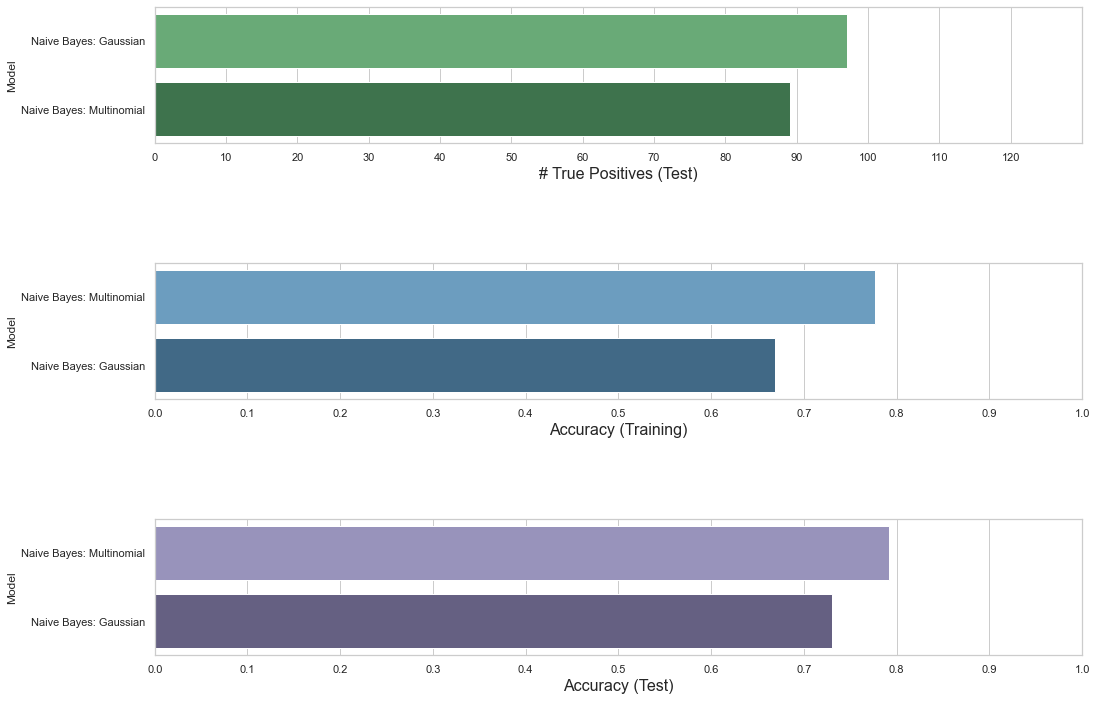

In [370]:
figz, axes = plt.subplots(3,1, figsize=(16,12))
figz.tight_layout(pad=8.0)

summary_table.sort_values(by=['True Positives'], ascending=False, inplace=True)
sns.barplot(x='True Positives', y='Model Name', data = summary_table, palette='Greens_d', ax = axes[0])
axes[0].set_xlabel('# True Positives (Test)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,130)
axes[0].set_xticks(np.arange(0, 130, 10))

summary_table.sort_values(by=['Accuracy (Training)'], ascending=False, inplace=True)
sns.barplot(x='Accuracy (Training)', y='Model Name', data = summary_table, palette='Blues_d', ax = axes[1])
axes[1].set_xlabel('Accuracy (Training)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)
axes[1].set_xticks(np.arange(0, 1.1, 0.1))

summary_table.sort_values(by=['Accuracy (Test)'], ascending=False, inplace=True)
sns.barplot(x='Accuracy (Test)', y='Model Name', data = summary_table, palette='Purples_d', ax = axes[2])
axes[2].set_xlabel('Accuracy (Test)', size=16)
axes[2].set_ylabel('Model')
axes[2].set_xlim(0,1.0)
axes[2].set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

Conclusion:
    
    Both Naive Bayes models suck at predicting surviors in the test dataset based on patterns found in the training dataset. I wonder if my model would have improved if I had imputed NA's found in the age column, rather than dropping them entirely. I also wonder if I should have dropped any other variable that may have added noise to the model. For example, I am unsure if Fare, Embarked, or Parch was dropped, it would have improved the model. I recommend using a different algorithm, such as a random forest, which may perform better than a specific combination of variables for NB. 